# Chapter 19: Dynamic Graph Theory Techniques for Node Ranking and Social Network Analysis

## 19.1 Uncovering Central Nodes based on Expected Traffic in a Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
def add_random_edge(G, node1, node2, prob_road=0.9, mean_drive_time=20):
    if np.random.binomial(1, prob_road):
        drive_time = np.random.normal(mean_drive_time)
        G.add_edge(node1, node2, travel_time=round(drive_time, 2))

def add_intercountry_edges(G):
    nodes = list(G.nodes(data=True))
    for node1, attributes1 in nodes[:-1]:
        country1 = attributes1['country_id']
        for node2, attributes2 in nodes[node1:]:
            if country1 != attributes2['country_id']:
                add_random_edge(G, node1, node2, prob_road=0.05, mean_drive_time=45)
    
    return G

def random_country(country_id):
    numTowns = np.random.randint(3, 10)
    G = nx.Graph()
    nodes = [(node_id, {'country_id': country_id}) for node_id in range(numTowns)]
    G.add_nodes_from(nodes)
    for node1, _ in nodes[:-1]:
        for node2, _ in nodes[node1 + 1:]:
            add_random_edge(G, node1, node2)

    return G

<class 'int'>


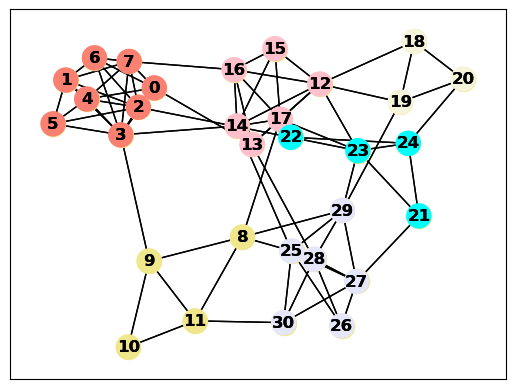

In [3]:
np.random.seed(1)
G = random_country(0)
for country_id in range(1, 6):
    G2 = random_country(country_id)
    G = nx.disjoint_union(G, G2)

G = add_intercountry_edges(G)
np.random.seed(1)
nx.draw_networkx(G, with_labels=True, node_color='khaki')

np.random.seed(1)
country_colors = ['salmon', 'khaki', 'pink', 'beige', 'cyan', 'lavender']
country_ids = [G.nodes[n]['country_id'] for n in G.nodes]
print(type(country_ids[0]))
node_colors = [country_colors[id_] for id_ in country_ids]
nx.draw_networkx(G, with_labels=True, node_color=node_colors)
plt.show() 

In [4]:
# Computing the degree of a single node
adjacency_matrix = nx.to_numpy_array(G)
degree_town_0 = adjacency_matrix[:,0].sum()
assert degree_town_0 == len(G[0])
assert degree_town_0 == G.degree(0)
print(f"Town 0 is connected by {degree_town_0:.0f} roads.")

Town 0 is connected by 5 roads.


* **Degee of Centrality**: Ranked importance of a node's degree

Town 3 is our most central town. It has 9 connecting roads.


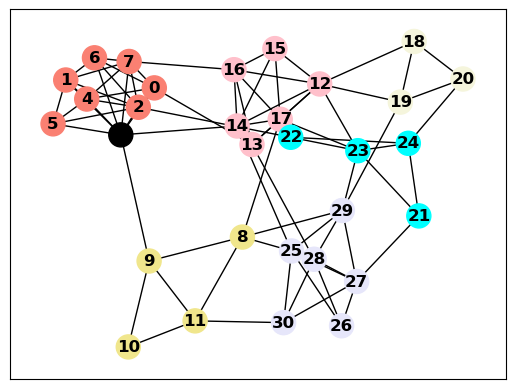

In [5]:
# Selecting a central node using degree of centrality
np.random.seed(1)
central_town = adjacency_matrix.sum(axis=0).argmax()
degree = G.degree(central_town)
print(f"Town {central_town} is our most central town. It has {degree} connecting roads.")
node_colors[central_town] = 'k'
nx.draw_networkx(G, with_labels=True, node_color=node_colors)
plt.show()

In [6]:
# Selecting a node with the second-highest degree of centrality
second_town = sorted(G.nodes, key=lambda x: G.degree(x), reverse=True)[1]
second_degree = G.degree(second_town)
print(f"Town {second_town} has {second_degree} connecting roads.")

Town 12 has 8 connecting roads.


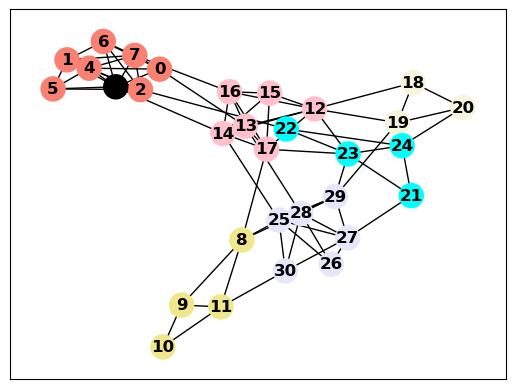

In [7]:
# Removing an edge from the most central node
np.random.seed(1)
G.remove_edge(3, 9)
assert G.degree(3) == G.degree(12)
nx.draw_networkx(G, with_labels=True, node_color=node_colors)
plt.show()

### 19.1.1 Measuring Centrality Using Traffic Simulations

In [8]:
# Simulating the random routes of a single car
np.random.seed(0)
def random_drive(num_stops=10):
    town = np.random.choice(G.nodes)
    for _ in range(num_stops):
        town = np.random.choice(G[town])
    
    return town

destination = random_drive()
print(f"After driving randomly, the car has reached Town {destination}.")

After driving randomly, the car has reached Town 24.


In [9]:
# Simulating traffic using 20,000 cars
import time
np.random.seed(0)
car_counts = np.zeros(len(G.nodes))
num_cars = 20000

start_time = time.time()
for _ in range(num_cars):
    destination = random_drive()
    car_counts[destination] += 1

central_town = car_counts.argmax()
traffic = car_counts[central_town]
running_time = time.time() - start_time
print(f"We ran a {running_time:.2f} second simulation.")
print(f"Town {central_town} has the most traffic.")
print(f"There are {traffic:.0f} cars in that town.")

We ran a 4.80 second simulation.
Town 12 has the most traffic.
There are 1015 cars in that town.


In [10]:
# Checking the traffic in Town 3
print(f"There are {car_counts[3]:.0f} cars in Town 3.")

There are 934 cars in Town 3.


In [11]:
# Converting traffic counts to probabilities
probabilities = car_counts / num_cars
for i in [12, 3]:
    prob = probabilities[i]
    print(f"The probability of winding up in Town {i} is {prob:.3f}.")

The probability of winding up in Town 12 is 0.051.
The probability of winding up in Town 3 is 0.047.


## 19.2 Computing Travel Probabilities Using Matrix Multiplication

In [12]:
# Computing the probability of travel to a neighboring town
num_neighbors = G.degree(0)
prob_travel = 1 / num_neighbors
print(f"The probability of traveling from Town 0 to one of its {G.degree(0)} neighboring towns is {prob_travel}")

The probability of traveling from Town 0 to one of its 5 neighboring towns is 0.2


In [13]:
# Computing a transition vector
transition_vector = np.array([0.2 if i in G[0] else 0 for i in G.nodes])

adjacency_matrix = nx.to_numpy_array(G)
v2 = np.array([1 if i in G[0] else 0 for i in G.nodes]) *0.2
v3 = adjacency_matrix[:,0] * 0.2
v4 = adjacency_matrix[:,0] / adjacency_matrix[:,0].sum()

for v in [v2, v3, v4]:
    assert np.array_equal(transition_vector, v)

print(transition_vector)

[0.  0.  0.  0.2 0.2 0.  0.2 0.2 0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]


In [14]:
# Computing a transition matrix
transition_matrix = adjacency_matrix / adjacency_matrix.sum(axis=0)
assert np.array_equal(transition_vector, transition_matrix[:,0])

In [15]:
# Computing travel probabilities using the transition matrix
v = np.ones(31) / 31
for _ in range(10):
    v = transition_matrix @ v

for i in [12, 3]:
    print(f"The probability of winding up in Town {i} is {v[i]:.3f}.")

The probability of winding up in Town 12 is 0.051.
The probability of winding up in Town 3 is 0.047.


### 19.2.1 Deriving PageRank Centrality from Probability Theory

In [16]:
# Computing a travel likelihood from a random starting location
prob = transition_matrix[0][3] / 31
print(f"Probability of starting in Town 3 and driving to Town 0 is {prob:.2f}")

Probability of starting in Town 3 and driving to Town 0 is 0.00


In [17]:
# Computing travel likelihoods of random routes leading to Town 0
for i in range(31):
    prob = transition_matrix[0][i] / 31
    if not prob:
        continue

    print(f"Probability of starting in Town {i} and driving to Town 0 is {prob:.4f}")

print("\nAll remaining transition probabilities are 0.0")

Probability of starting in Town 3 and driving to Town 0 is 0.0040
Probability of starting in Town 4 and driving to Town 0 is 0.0054
Probability of starting in Town 6 and driving to Town 0 is 0.0065
Probability of starting in Town 7 and driving to Town 0 is 0.0046
Probability of starting in Town 13 and driving to Town 0 is 0.0054

All remaining transition probabilities are 0.0


In [18]:
# Computing the probability that the first stop is Town 0
np.random.seed(0)
prob = sum(transition_matrix[0][i] / 31 for i in range(31))
frequency = np.mean([random_drive(num_stops=1) == 0 for _ in range(50000)])

print(f"Probability of making our first stop in Town 0: {prob:.3f}")
print(f"Frequency with wich our first stop is Town 0: {frequency:.3f}")

Probability of making our first stop in Town 0: 0.026
Frequency with wich our first stop is Town 0: 0.026


In [19]:
# Computing a travel probability using a vector dot product
v = np.ones(31) / 31
assert transition_matrix[0] @ v == prob

In [20]:
# Computing all first stop probabilities
np.random.seed(0)
stop_1_probabilities = transition_matrix @ v
prob = stop_1_probabilities[12]
frequency = np.mean([random_drive(num_stops=1) == 12 for _ in range(50000)])

print("First stop probabilities:")
print(np.round(stop_1_probabilities, 3))
print(f"\nProbability of making our first stop in Town 12: {prob:.3f}")
print(f"Frequency with wich our first stop is Town 12: {frequency:.3f}")

First stop probabilities:
[0.026 0.033 0.045 0.046 0.033 0.019 0.025 0.038 0.033 0.031 0.019 0.041
 0.052 0.03  0.036 0.019 0.031 0.039 0.023 0.031 0.027 0.019 0.018 0.044
 0.038 0.046 0.015 0.045 0.04  0.035 0.023]

Probability of making our first stop in Town 12: 0.052
Frequency with wich our first stop is Town 12: 0.052


In [21]:
# Computing all second-stop probabilities
np.random.seed(0)
stop_2_probabilities = transition_matrix @ transition_matrix @ v
prob = stop_2_probabilities[12]
frequency = np.mean([random_drive(num_stops=2) == 12 for _ in range(50000)])

print("Second stop probabilities:")
print(np.round(stop_2_probabilities, 3))
print(f"\nProbability of making our second stop in Town 12: {prob:.3f}")
print(f"Frequency with wich our second stop is Town 12: {frequency:.3f}")

Second stop probabilities:
[0.027 0.033 0.038 0.043 0.033 0.023 0.028 0.039 0.039 0.026 0.021 0.032
 0.048 0.034 0.039 0.023 0.032 0.041 0.023 0.029 0.025 0.024 0.023 0.04
 0.029 0.043 0.021 0.036 0.036 0.042 0.031]

Probability of making our second stop in Town 12: 0.048
Frequency with wich our second stop is Town 12: 0.048


In [22]:
# Computing the Nth-stop probabilities
def compute_stop_likelihoods(M, num_stops):
    v = np.ones(M.shape[0]) / M.shape[0]
    for _ in range(num_stops):
        v = M @ v

    return v

stop_10_probabilities = compute_stop_likelihoods(transition_matrix, 10)
prob = stop_10_probabilities[12]

print("Tenth stop probabilities:")
print(np.round(stop_2_probabilities, 3))
print(f"\nProbability of making our second stop in Town 12: {prob:.3f}")

Tenth stop probabilities:
[0.027 0.033 0.038 0.043 0.033 0.023 0.028 0.039 0.039 0.026 0.021 0.032
 0.048 0.034 0.039 0.023 0.032 0.041 0.023 0.029 0.025 0.024 0.023 0.04
 0.029 0.043 0.021 0.036 0.036 0.042 0.031]

Probability of making our second stop in Town 12: 0.051


### 19.2.2 Computing PageRank Centrality using NetworkX

In [23]:
# Computing PageRank centrality using NetworkX
centrality = nx.pagerank(G)[12]
print(f"The PageRank centrality of Town 12 is {centrality:.3f}")

The PageRank centrality of Town 12 is 0.048


In [24]:
# Incorporating randomized teleportation into our model
new_matrix = 0.85 * transition_matrix + 0.15 / 31
stop_10_probabilities = compute_stop_likelihoods(new_matrix, 10)

prob = stop_10_probabilities[12]
print(f"The probability of winding up in Town 12 is {prob:.3f}.")

The probability of winding up in Town 12 is 0.048.


In [25]:
# Computing he probability after 1000 stops
prob = compute_stop_likelihoods(new_matrix, 1000)[12]
print(f"The probability of winding up in Town 12 is {prob:.3f}.")

The probability of winding up in Town 12 is 0.048.


Given any graph G, compute its PageRank centralities usig the following steps:
1. Obtain the graph’s adjacency matrix M.  
2. Convert the adjacency matrix into the transition matrix by running M = M / M.sum(axis=0).  
3. Update M to allow for random teleportation. This is done by taking the weighted mean of M and 1 / n, where n equals the number of nodes in the graph. The weights are usually set to 0.85 and 0.15, so the weighted mean equals 0.85 * M + 0.15 / n.  
4. Return the largest (and only) eigenvector of M. We can compute the eigenvector by running v = M @ v across approximately 10 iterations. Initially, vector v is set to np.ones(n) / n

## 19.3 Comminuty Detection using Markov Clustering

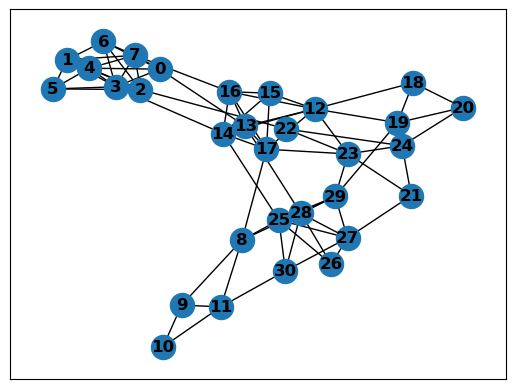

In [26]:
# Plotting G without country-based coloring
np.random.seed(1)
nx.draw_networkx(G)
plt.show()

In [27]:
# Comparing computed flow to random simulations
np.random.seed(0)
flow_matrix = transition_matrix @ transition_matrix

simulated_flow_matrix = np.zeros((31, 31))
num_simulations = 10000
for town_i in range(31):
    for _ in range(num_simulations):
        town_j = np.random.choice(G[town_i])
        town_k = np.random.choice(G[town_j])
        
        # Tracks the frequency with wich we travel from Town i to Town k after 2 stops
        simulated_flow_matrix[town_k][town_i] += 1

simulated_flow_matrix /= num_simulations
assert np.allclose(flow_matrix, simulated_flow_matrix, atol=1e-2)

Mean flow within a country: 0.116
Mean flow between different countries: 0.042
The minimum intra-country flow is approximately 0.042
132 inter-country flows fall below that threshold.


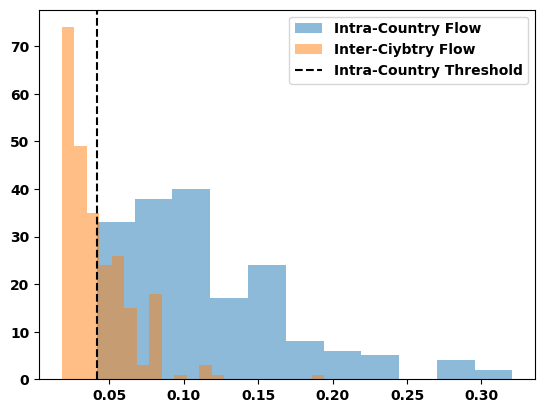

In [28]:
# Comparing intra- and inter-country flow distributions
def compare_flow_distributions():
    country_flows = []
    between_country_flows = []
    for i in range(31):
        country = G.nodes[i]['country_id']
        nonzero_indices = np.nonzero(flow_matrix[:,i])[0]

        for j in nonzero_indices:
            flow = flow_matrix[j][i]

            if country == G.nodes[j]['country_id']:
                country_flows.append(flow)
            else:
                between_country_flows.append(flow)

    mean_intra_flow = np.mean(country_flows)
    mean_inter_flow = np.mean(between_country_flows)
    print(f"Mean flow within a country: {mean_intra_flow:.3f}")
    print(f"Mean flow between different countries: {mean_inter_flow:.3f}")

    threshold = min(country_flows)
    # Tracks all inter-country flows that are below the minimum intra-country flows
    num_below = len([flow for flow in between_country_flows if flow < threshold])
    print(f"The minimum intra-country flow is approximately {threshold:.3f}")
    print(f"{num_below} inter-country flows fall below that threshold.")

    plt.hist(country_flows, bins='auto', alpha=0.5, label='Intra-Country Flow')
    plt.hist(between_country_flows, bins='auto', alpha=0.5, label='Inter-Ciybtry Flow')

    plt.axvline(threshold, linestyle='--', color='k', label='Intra-Country Threshold')
    plt.legend()
    plt.show()

compare_flow_distributions()


In [29]:
# Decreasing the separation threshold
num_below = np.count_nonzero((flow_matrix > 0.0) & (flow_matrix < 0.01))
print(f"{num_below} inter-country flows fall below a threshold of 0.01")

0 inter-country flows fall below a threshold of 0.01


In [30]:
# Exaggerating value difference through vector inflation
v = np.array([0.7, 0.3])
v2 = v ** 2
v2 /= v2.sum()
assert v.mean() == round(v2.mean(), 10)
assert v2[0] > v[0]
assert v2[1] < v[1]
print(v2)

[0.84482759 0.15517241]


Mean flow within a country: 0.146
Mean flow between different countries: 0.020
The minimum intra-country flow is approximately 0.012
118 inter-country flows fall below that threshold.


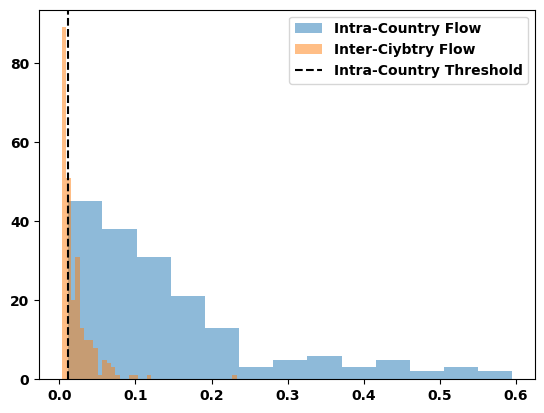

In [31]:
# Exaggerating flow differences through vector inflation
def inflate(matrix):
    matrix = matrix ** 2
    return matrix / matrix.sum(axis=0)

flow_matrix = inflate(flow_matrix)
compare_flow_distributions()

Mean flow within a country: 0.159
Mean flow between different countries: 0.004
The minimum intra-country flow is approximately 0.001
541 inter-country flows fall below that threshold.


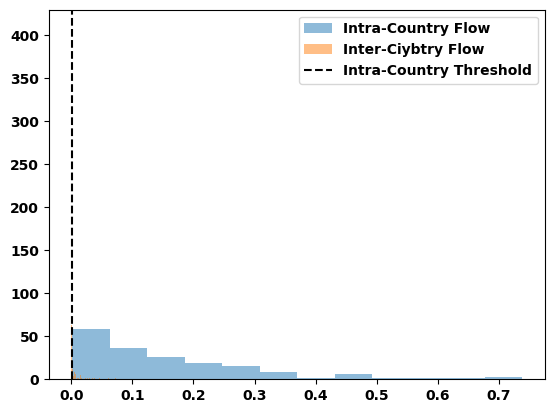

In [32]:
# Inflating the product of flow_matrix with itself
flow_matrix = inflate(flow_matrix @ flow_matrix)
compare_flow_distributions()

**Markov Clustering Algorithm**: Build up roads with high traffic and decay roads with low traffic; ends up with clustering close cities

In [33]:
# Inflating the product of flow_matrix repeatedly with itself
for _ in range(20):
    flow_matrix = inflate(flow_matrix @ flow_matrix)

In [34]:
# Selecting suspected inter-country edges
suspected_inter_country = [(i,j) for (i,j) in G.edges() if not (flow_matrix[i][j] or flow_matrix[j][i])]
num_suspected = len(suspected_inter_country)
print(f"We suspect {num_suspected} edges of appearing between countries.")

We suspect 57 edges of appearing between countries.


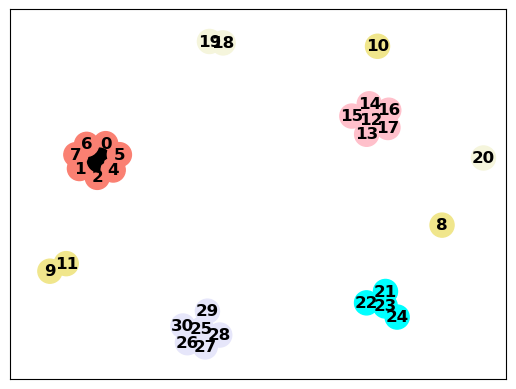

In [35]:
# Deleting suspected inter-country edges
np.random.seed(1)
G_copy = G.copy()
G_copy.remove_edges_from(suspected_inter_country)
nx.draw_networkx(G_copy, with_labels=True, node_color=node_colors)
plt.show()

In [36]:
# Improving flow by adding self-loops
def compute_flow(adjacency_matrix):
    transaction_matrix = adjacency_matrix / adjacency_matrix.sum(axis=0)
    return (transaction_matrix @ transaction_matrix)[1][0]

M1 = np.array([[0, 1], [1, 0]])
M2 = np.array([[1, 1], [1, 1]])
flow1, flow2 = [compute_flow(M) for M in [M1, M2]]
print(f"The flow from A to B without self-loops is {flow1}")
print(f"The flow from A to B with self-loops is {flow2}")

The flow from A to B without self-loops is 0.0
The flow from A to B with self-loops is 0.5


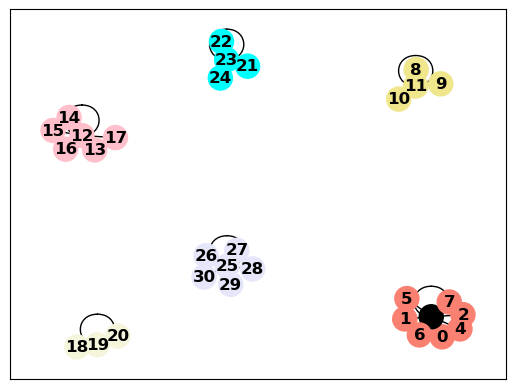

In [37]:
# Defining an MCL function
def run_mcl(G):
    for i in G.nodes:
        G.add_edge(i, i)

    adjacency_matrix = nx.to_numpy_array(G)
    transition_matrix = adjacency_matrix / adjacency_matrix.sum(axis=0)
    flow_matrix = inflate(transition_matrix @ transition_matrix)

    for _ in range(20):
        flow_matrix = inflate(flow_matrix @ flow_matrix)

    G.remove_edges_from([(i, j) for i, j in G.edges() if not (flow_matrix[i][j] or flow_matrix[j][i])])

G_copy = G.copy()
run_mcl(G_copy)
nx.draw_networkx(G_copy, with_labels=True, node_color=node_colors)
plt.show()

In [38]:
# Using path lengths to uncover a country cluster
component = nx.shortest_path_length(G_copy, source=0).keys()
country_id = G.nodes[0]['country_id']
for i in component:
    assert G.nodes[i]['country_id'] == country_id

print(f"The following towns are found in Country {country_id}:")
print(sorted(component))


The following towns are found in Country 0:
[0, 1, 2, 3, 4, 5, 6, 7]


In [39]:
# Extracting all the clustered connected countries
for component in nx.connected_components(G_copy):
    country_id = G.nodes[list(component)[0]]['country_id']
    print(f"\nThe following towns are found n Country {country_id}:")
    print(component)


The following towns are found n Country 0:
{0, 1, 2, 3, 4, 5, 6, 7}

The following towns are found n Country 1:
{8, 9, 10, 11}

The following towns are found n Country 2:
{12, 13, 14, 15, 16, 17}

The following towns are found n Country 3:
{18, 19, 20}

The following towns are found n Country 4:
{24, 21, 22, 23}

The following towns are found n Country 5:
{25, 26, 27, 28, 29, 30}


In [40]:
# Importing from the Markov clustering library
from markov_clustering import get_clusters, run_mcl

In [41]:
# Clustering with the Markov clustering library
adjacency_matrix = nx.to_numpy_array(G)
clusters = get_clusters(run_mcl(adjacency_matrix))

for cluster in clusters:
    country_id = G.nodes[cluster[0]]['country_id']
    print(f"\nThe following towns are found in Country {country_id}:")
    print(cluster)


The following towns are found in Country 0:
(0, 1, 2, 3, 4, 5, 6, 7)

The following towns are found in Country 1:
(8, 9, 10, 11)

The following towns are found in Country 2:
(12, 13, 14, 15, 16, 17)

The following towns are found in Country 3:
(18, 19, 20)

The following towns are found in Country 4:
(21, 22, 23, 24)

The following towns are found in Country 5:
(25, 26, 27, 28, 29, 30)


## 19.4 Uncovering Friend Groups in Social Networks

In [42]:
# Loading the karate club graph
G_karate = nx.karate_club_graph()
print(G_karate.nodes(data=True))

[(0, {'club': 'Mr. Hi'}), (1, {'club': 'Mr. Hi'}), (2, {'club': 'Mr. Hi'}), (3, {'club': 'Mr. Hi'}), (4, {'club': 'Mr. Hi'}), (5, {'club': 'Mr. Hi'}), (6, {'club': 'Mr. Hi'}), (7, {'club': 'Mr. Hi'}), (8, {'club': 'Mr. Hi'}), (9, {'club': 'Officer'}), (10, {'club': 'Mr. Hi'}), (11, {'club': 'Mr. Hi'}), (12, {'club': 'Mr. Hi'}), (13, {'club': 'Mr. Hi'}), (14, {'club': 'Officer'}), (15, {'club': 'Officer'}), (16, {'club': 'Mr. Hi'}), (17, {'club': 'Mr. Hi'}), (18, {'club': 'Officer'}), (19, {'club': 'Mr. Hi'}), (20, {'club': 'Officer'}), (21, {'club': 'Mr. Hi'}), (22, {'club': 'Officer'}), (23, {'club': 'Officer'}), (24, {'club': 'Officer'}), (25, {'club': 'Officer'}), (26, {'club': 'Officer'}), (27, {'club': 'Officer'}), (28, {'club': 'Officer'}), (29, {'club': 'Officer'}), (30, {'club': 'Officer'}), (31, {'club': 'Officer'}), (32, {'club': 'Officer'}), (33, {'club': 'Officer'})]


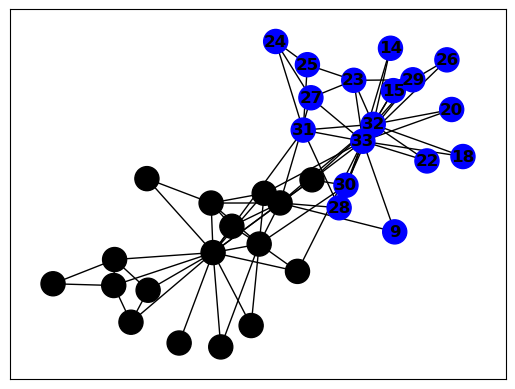

In [43]:
# Visualizing the karate club graph
np.random.seed(2)
club_to_color = {'Mr. Hi': 'k', 'Officer': 'b'}
node_colors = [club_to_color[G_karate.nodes[i]['club']] for i in G_karate]
nx.draw_networkx(G_karate, node_color=node_colors)

In [44]:
# Clustering the karate club graph
adjacency_matrix = nx.to_numpy_array(G_karate)
clusters = get_clusters(run_mcl(adjacency_matrix))
for i, cluster in enumerate(clusters):
    print(f"Cluster {i}:\n{cluster}\n")

Cluster 0:
(0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21)

Cluster 1:
(8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33)

Cluster 2:
(31,)



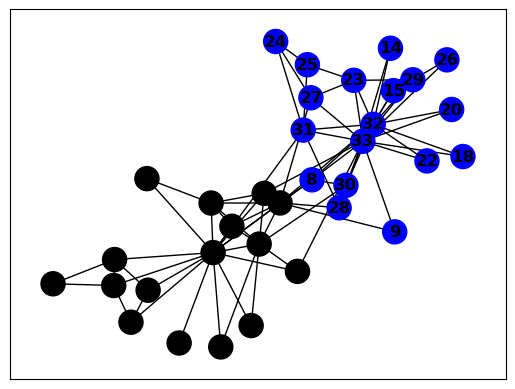

In [45]:
# Coloring the plotted graph based on cluster
np.random.seed(2)
cluster_0, cluster_1, cluster_2 = clusters
node_colors = ['k' if i in cluster_0 else 'b' for i in G_karate.nodes]

nx.draw_networkx(G_karate, node_color=node_colors)
plt.show()

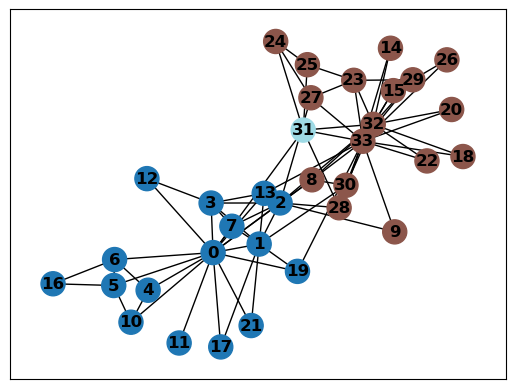

In [46]:
# Coloring social graph clusters automatically
np.random.seed(2)
for cluster_id, node_indices in enumerate(clusters):
    for i in node_indices:
        G_karate.nodes[i]['cluster_id'] = cluster_id

node_colors = [G_karate.nodes[n]['cluster_id'] for n in G_karate.nodes]
nx.draw_networkx(G_karate, node_color=node_colors, cmap=plt.cm.tab20)
plt.show()

Key Words / Notes:
* **Degree**: Edge count of a node in an undirected graph; can compute by summing over the columns of the graph's adjacency matrix
* **Node Centrality**: Any measure of a node's importance
* **Degree of Centrality**: Ranked importance based on a node's degree
* Sometimes the degree of centrality is an inadequate measure of node importance. We can better derive centrality by simulating random traffic in the network. The traffic can be converted into a probability of randomly winding up at a particular node.
* **Transition Matrix**: Tracks the likelihood of randomly traveling from node i to node j; repeatly taking the product of the transition atrix anda probaboility vector produces a vector of final end-point likelihoods; higher likelihoods correcspond  to more central nodes
* **PageRank Cenrality**: Equal to the eigen vector of the transition matrix (obtained through method similar to power method with repeated products of the transition matrix)
* **Communities**: Tightly connected clusters of nodes
* **Community Structure**: Graphs with clearly visible communities
* **Community Detection**: The process of uncovering communities in graphs
* **Markov Cluster Algorithm (MCL)**: Algorithm that detects communities in graphs; taking the product of the transition matrix with itself produces a flow matrix; lower flow values are more likely to correspond with inter-communty edges; further amplified the difference between high and low flows with *inflation*; Iteratively repeating matrix multiplication and inflation causes inter-community flows to drop to zero; then, deleting zero-flow edges copletely isolates the graph's communities; these isolated components can be identified with a variant of the shortest path length algorithm
* **Inflation**: way of increasing large values and decreasing small values in a vector; square the vector, then divide by the sum of it
* **Stochastic Flow**: Multistop transition matrix; 
* **Social Networks**: Edges represent relationships between people; they commonly contain a community structure, so we can use MCL to detect clusters of friends in these networks